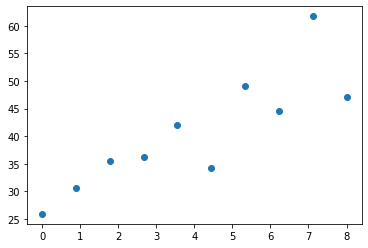

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, expon
# generate data
n = 10
sigma = 5
data = pd.DataFrame(columns=['x', 'y'])
data['x'] = np.linspace(0, 8, n)
k = 3.4
c = 23
data['y'] = k*data['x'] + c + np.random.randn(n)*sigma
# plot data
plt.scatter(data['x'], data['y'])

In [34]:
# form combinations of parameters and define their priors
from itertools import product

# create parameter space for slope and intercept
resolution = 200
data_slope = np.linspace(-10, 10, num=resolution)
data_inter = np.linspace(-50, 50, num=resolution)
data_sigma = np.linspace(0.001, 50, num=resolution)

# create dataframe for parameters
df = pd.DataFrame(columns=['slope','intercept', 'sigma', 'prior'])
# parameter combinations
comb =list(product(data_slope, data_inter, data_sigma))
temp = pd.DataFrame(data=comb, columns=['slope','intercept', 'sigma'])

df['slope'] = temp['slope']
df['intercept'] = temp['intercept']
df['sigma'] = temp['sigma']
slope_prior = norm(1, 5).pdf(df['slope'])
intercept_prior = norm(20, 5).pdf(df['intercept'])
sigma_prior = expon(0, 10).pdf(df['sigma'])
df['prior'] = slope_prior*intercept_prior*sigma_prior
df.head()


,slope,intercept,sigma,prior
0,-10.0,-50.0,0.001000,1.555911e-47
1,-10.0,-50.0,0.252251,1.517306e-47
2,-10.0,-50.0,0.503503,1.479658e-47
3,-10.0,-50.0,0.754754,1.442945e-47
4,-10.0,-50.0,1.006005,1.407142e-47


In [35]:
# form temporary table for parameters and data
# temp indexes for full join
data['temp'] = 1
df['temp'] = 1

# save old indexes before join
df['org_idx'] = df.index
# full join
df = pd.merge(df, data, on=['temp'])
df.head()

,slope,intercept,sigma,prior,temp,org_idx,x,y
0,-10.0,-50.0,0.001,1.555911e-47,1,0,0.000000,25.929033
1,-10.0,-50.0,0.001,1.555911e-47,1,0,0.888889,30.596995
2,-10.0,-50.0,0.001,1.555911e-47,1,0,1.777778,35.457108
3,-10.0,-50.0,0.001,1.555911e-47,1,0,2.666667,36.208518
4,-10.0,-50.0,0.001,1.555911e-47,1,0,3.555556,42.112194


In [36]:
# calculate likelihoods

df['residual'] = df['y'] - (df['slope'] * df['x'] + df['intercept'])
df['likelihood'] = norm(0, df['sigma']).pdf(df['residual'])

# group by slope and intercept (=org_idx) to get product of likelihoods per parameters
df = df.groupby(['org_idx'], as_index=False).agg({'slope': 'first', 'intercept': 'first', 'sigma': 'first', 'prior': 'first', 'likelihood': 'prod'})

df.head()

,org_idx,slope,intercept,sigma,prior,likelihood
0,0,-10.0,-50.0,0.001000,1.555911e-47,0.0
1,1,-10.0,-50.0,0.252251,1.517306e-47,0.0
2,2,-10.0,-50.0,0.503503,1.479658e-47,0.0
3,3,-10.0,-50.0,0.754754,1.442945e-47,0.0
4,4,-10.0,-50.0,1.006005,1.407142e-47,0.0


In [37]:
# calculate posterior
df['posterior'] = df['prior'] * df['likelihood']
# normalize
df['posterior'] = df['posterior'] / df['posterior'].sum()
df.head()

,org_idx,slope,intercept,sigma,prior,likelihood,posterior
0,0,-10.0,-50.0,0.001000,1.555911e-47,0.0,0.0
1,1,-10.0,-50.0,0.252251,1.517306e-47,0.0,0.0
2,2,-10.0,-50.0,0.503503,1.479658e-47,0.0,0.0
3,3,-10.0,-50.0,0.754754,1.442945e-47,0.0,0.0
4,4,-10.0,-50.0,1.006005,1.407142e-47,0.0,0.0


5.026025125628141
5.277276381909548


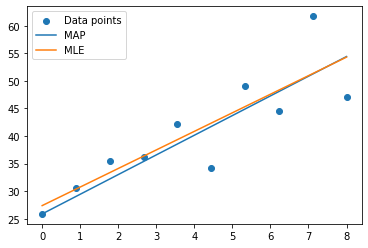

In [38]:
# plot data points
plt.scatter(data['x'], data['y'])
# plot bayes
idx = df['posterior'].argmax()
k = df['slope'][idx]
c = df['intercept'][idx]
plt.plot(data['x'], data['x']*k + c)
print(df['sigma'][idx])
# plot max likelihood
idx = df['likelihood'].argmax()
k = df['slope'][idx]
c = df['intercept'][idx]
plt.plot(data['x'], data['x']*k + c)
plt.legend(['Data points', 'MAP', 'MLE'])

print(df['sigma'][idx])
